In [256]:
import pandas as pd

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS

import keras
from  keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt  

In [257]:
df_train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",sep=';',names=['text','sentiment'])
df_val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",sep=';',names=['text','sentiment'])
df_test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",sep=';',names=['text','sentiment'])

In [258]:
df_train.head()

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


# Exploring the Data

### Checking for null values

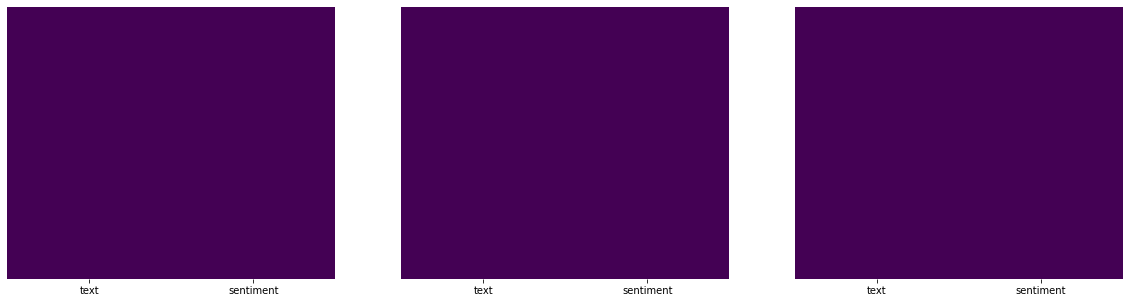

In [260]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
i = 0
for df in data:
    sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis', ax=ax[i])
    i += 1

no values are null

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


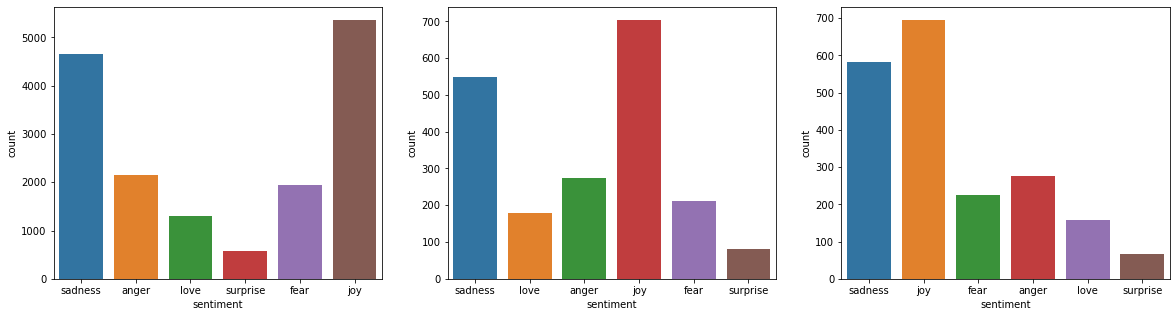

In [261]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
i = 0
for df in data:
    sns.countplot(df.sentiment,ax=ax[i])
    i += 1

As seen above the dataset is quite unbalanced. An unbalanced dataset will bias the prediction model towards the more common class. We can deal with this in a variety of ways. Undersampling, removing data points randomly from the majority class till the classes are balanced, but this could lead to information loss and poor model traning. Oversampling, replicate minority class data points randomly, can lead to overfit and inaccuracy. Most other techniques do not work well with text data (e.g. SMOTE). I believe the best way to go about this would be to undersample the dataset, information loss intuetively seems minimal as the text data is pretty similar all around. One thing to consider could be to remove the "surprise" class as its instances are too low compare the next lowest, "love". 

In [262]:
for df in data:
    print(df.sentiment.value_counts())

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: sentiment, dtype: int64
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: sentiment, dtype: int64


surprise only has 572 instances compared to 5362 instaces of joy. This will not be good for the true accuracy of the model (Accuracy Paradox). Lets remove the surprise class and then undersample the entire dataset to ~2000. Not able to find viable way, research further.

In [263]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 
).generate(str(data))
    return wordcloud

In [264]:
categories = df_train["sentiment"].unique()

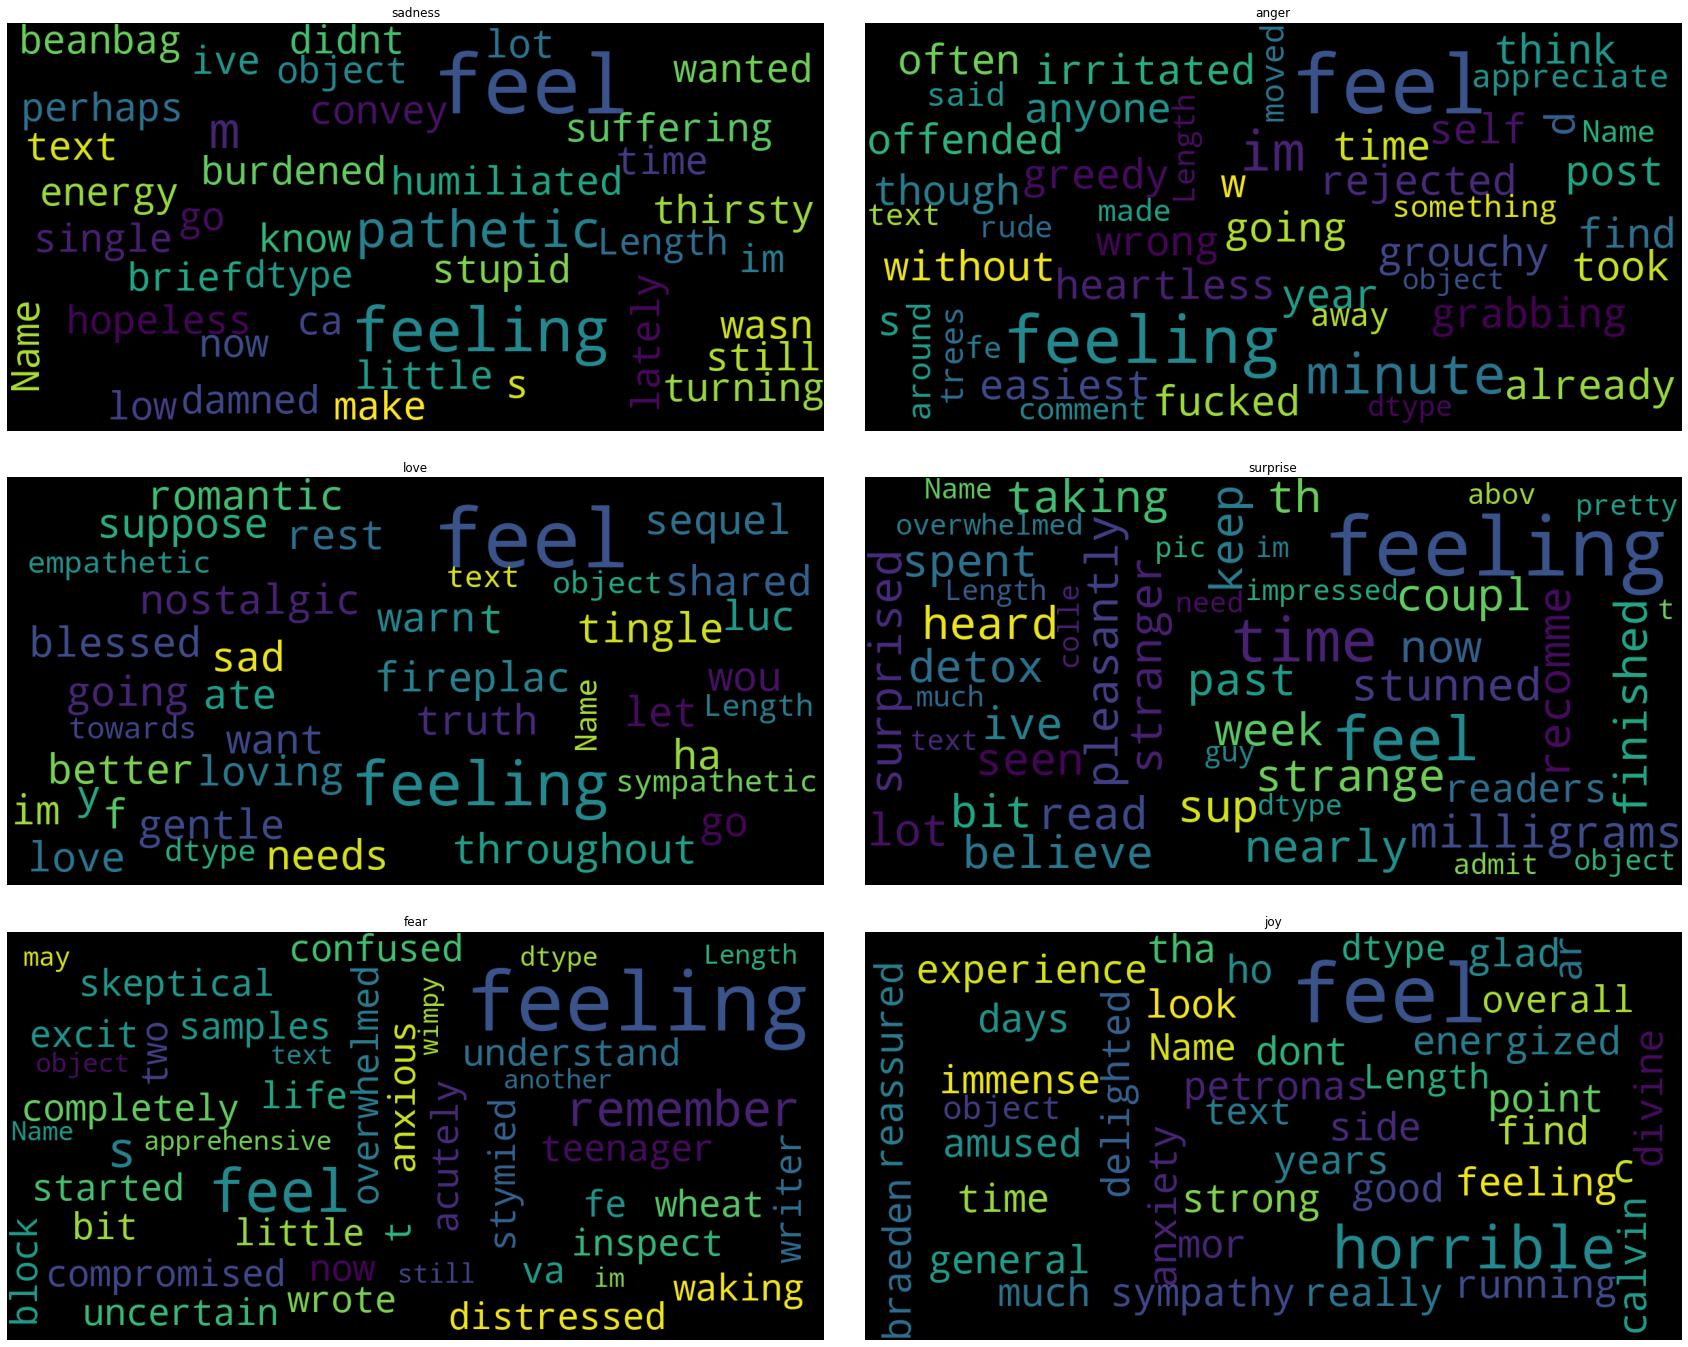

In [265]:
fig, axes = plt.subplots(ncols=2, nrows=3,figsize=(30,25))
plt.axis('off')
for category, ax in zip(categories, axes.flat):
    wordcloud = show_wordcloud(df_train[df_train["sentiment"]==category]['text'])
    ax.imshow(wordcloud)
    ax.title.set_text(category)
    ax.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0.01)

# Preprocessing Data

In [125]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [266]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    words = word_tokenize(text) # tokenized words
    
    filter_text = [w for w in words if not w in stopwords]
    
    for text in filter_text:
        text = lemmatizer.lemmatize(text)
    
    return " ".join(filter_text)

In [267]:
print(df_train.text.head()[4])
preprocess(df_train.text.head()[4])

i am feeling grouchy


'feeling grouchy'

In [268]:
# applying preprocess to the sets
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_val.text = df_val.text.apply(lambda x: preprocess(x))

In [269]:
df_train.head()

,text,sentiment
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,feeling nostalgic fireplace will know still pr...,love
4,feeling grouchy,anger


<AxesSubplot:>

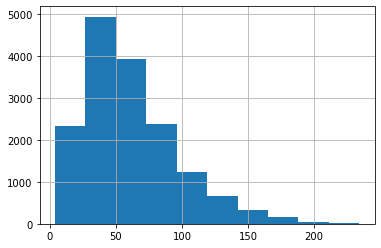

In [270]:
df_train['text'].str.len().hist()

In [271]:
min(df['text'].str.len()), max(df['text'].str.len())

(8, 205)

The text ranges from 8 to 205 characters. 

# Tokenizing to convert sentences into word vectors

In [272]:
X = df_train['text']

In [273]:
tokenizer=Tokenizer(15212,lower=True,oov_token='UNK')
tokenizer.fit_on_texts(X)

In [274]:
len(tokenizer.word_index)

15071

In [275]:
X_train=tokenizer.texts_to_sequences(X)
X_train_pad=pad_sequences(X_train,maxlen=80,padding='post') # maxlen is 80 since max sequence is 35

In [276]:
df_train['sentiment']=df_train.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [277]:
Y_train=df_train['sentiment'].values

# One Hot Encoding

In [278]:
Y_train_f=to_categorical(Y_train)

In [279]:
X_val = df_val['text']
Y_val = df_val.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [282]:
X_val_f=tokenizer.texts_to_sequences(X_val)
X_val_pad=pad_sequences(X_val_f,maxlen=80,padding='post')

In [283]:
Y_val_f=to_categorical(Y_val)

In [284]:
Y_val_f[:6]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

# Model Creation

In [285]:
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional,Dense,Embedding,Dropout

In [286]:
model=Sequential()
model.add(Embedding(15212,64,input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 64)            973568    
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 64)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 80, 160)           92800     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 320)               410880    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1926      
Total params: 1,479,174
Trainable params: 1,479,174
Non-trainable params: 0
_________________________________________________________________
None


In [287]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [289]:
hist=model.fit(X_train_pad,Y_train_f,epochs=12,validation_data=(X_val_pad,Y_val_f))

Epoch 1/12
500/500 [==============================] - 22s 34ms/step - loss: 1.4230 - accuracy: 0.4259 - val_loss: 0.5000 - val_accuracy: 0.8320
Epoch 2/12
500/500 [==============================] - 15s 31ms/step - loss: 0.4110 - accuracy: 0.8602 - val_loss: 0.2358 - val_accuracy: 0.9075
Epoch 3/12
500/500 [==============================] - 15s 31ms/step - loss: 0.1795 - accuracy: 0.9362 - val_loss: 0.1816 - val_accuracy: 0.9250
Epoch 4/12
500/500 [==============================] - 15s 31ms/step - loss: 0.1299 - accuracy: 0.9500 - val_loss: 0.1987 - val_accuracy: 0.9195
Epoch 5/12
500/500 [==============================] - 15s 30ms/step - loss: 0.1161 - accuracy: 0.9530 - val_loss: 0.1874 - val_accuracy: 0.9235
Epoch 6/12
500/500 [==============================] - 15s 31ms/step - loss: 0.0857 - accuracy: 0.9679 - val_loss: 0.2160 - val_accuracy: 0.9170
Epoch 7/12
500/500 [==============================] - 15s 30ms/step - loss: 0.0764 - accuracy: 0.9704 - val_loss: 0.2068 - val_accuracy:

# Plotting Loss and Accuracy

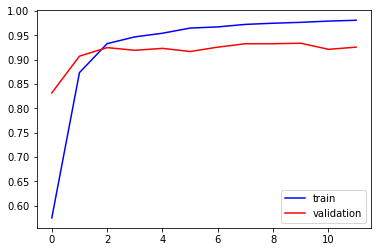

In [290]:
plt.plot(hist.history['accuracy'],c='b',label='train')
plt.plot(hist.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

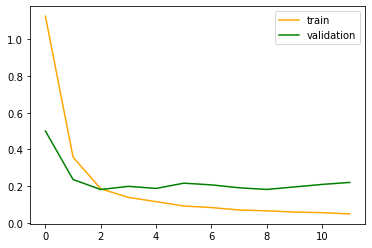

In [291]:
plt.plot(hist.history['loss'],c='orange',label='train')
plt.plot(hist.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.show()

# Accuracy on test data

In [319]:
X_test=df_test['text']
Y_test=df_test.sentiment.replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})

In [320]:
X_test_f=tokenizer.texts_to_sequences(X_test)
X_test_pad=pad_sequences(X_test_f,maxlen=80,padding='post')

In [321]:
Y_test_f=to_categorical(Y_test)

In [322]:
model.evaluate(X_test_pad,Y_test_f)

63/63 [==============================] - 1s 10ms/step - loss: 0.4114 - accuracy: 0.8845


[0.4114183783531189, 0.8845000267028809]

# Confusion Matrix

In [323]:
Y_pred=model.predict_classes(X_test_pad)

In [325]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       695
           1       0.88      0.92      0.90       275
           2       0.72      0.88      0.79       159
           3       0.99      0.89      0.94       581
           4       0.68      0.95      0.79       224
           5       0.69      0.79      0.74        66

    accuracy                           0.88      2000
   macro avg       0.82      0.88      0.85      2000
weighted avg       0.90      0.88      0.89      2000



# Predicting

In [296]:
def get_key(value):
    dictionary={'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5}
    for key,val in dictionary.items():
          if (val==value):
            return key
        
def predict(sentence):
    sentence_lst=[]
    sentence_lst.append(sentence)
    sentence_seq=tokenizer.texts_to_sequences(sentence_lst)
    sentence_padded=pad_sequences(sentence_seq,maxlen=80,padding='post')
    ans=get_key(model.predict_classes(sentence_padded))
    print("The emotion predicted is",ans)

In [326]:
predict(str(input()))

working
The emotion predicted is joy


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
